In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration - If you have CUDA configured, you must use it. Try training with CPU and observe what happens
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Setting a seed for torch
'''step - Your seed will be the last 6 digits of your A# excluding any leading zeros'''
torch.manual_seed(313514) 


In [3]:
#Check your Current Working Directory
!pwd

/home/codygrogan/Classes/DeepLearningTheory/HW-3


In [4]:
#Set Batch Size
'''Step - Set the correct batch size. '''
batch_size = 40


# Download MNIST dataset to local drive. A new folder "data" will be created in the current directory to store data
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader for shuffling and batching.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)



In [5]:
# Hyper-parameters - We are specifying these apriori
#Network Architecture
input_size = 784
'''Output layer has 10 nodes because we want to predict 10 classes'''
num_classes = 10 

#Training Parameters
''' - Define the number of epochs and observe the changes'''
num_epochs = 30


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        '''
        Step - Define the N/w architecture. Use RELU Activation
        '''
        ''' Step - Define a Linear Unit with input size and hidden size''' 
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu1 = nn.ReLU()
        ''' Step - Define a Linear Unit with hidden size and hidden size'''
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
      
        ''' Step - Define a Linear Unit with input size and output size (number of classes for MNIST)''' 
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        '''
        Step - Forward Propagate through the layers as defined above. Fill in params in place of ...
        '''
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        out = self.sigmoid(x)
        return out



# Define the Loss Function and optimizer
'''Step - Define a proper loss function'''
criterion = torch.nn.CrossEntropyLoss()



In [6]:
# Train the model
'''step - choose different learning rates and store them in a list and observe the changes '''
learning_rates = [.25]
'''Vary this number and observe the changes, define a list of possible values'''
hidden_sizes = [200]

for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        total_step = len(train_loader)
        #Define the Model Object and your optimizer
        model = NeuralNet(input_size, hidden_size, num_classes).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001) 
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):  
                # Move tensors to the configured device
                images = images.reshape(-1, 28*28).to(device)
                labels = labels.to(device)

                # Forward pass
                '''Step - Get Network outputs with forward propagation with current network weights'''
                outputs = model(images)
                '''Step - Get Loss by comparing outputs with True Labels after forward propagation'''
                loss = criterion(outputs, labels)

                # Backward and optimize
                
                '''Step - ... below needs to be replaced with functions'''
                '''Step - clear the gradients after each pass - Strongly recommended'''
                optimizer.zero_grad()
                '''Backpropagate the Loss to calculate gradient for each weight'''
                loss.backward()
                '''Update the weight using the learning rate'''
                optimizer.step()

                #Print Progress every 100 steps
                #if (i+1) % 100 == 0:
                #   print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                    
    # Test the model once you finish training 

        with torch.no_grad(): # In test phase, we don't need to compute gradients (for memory efficiency)
            correct = 0
            total = 0
            for images, labels in test_loader:
                
                '''Step - Move images to device after appropriate reshaping'''
                images = images.reshape(-1, 28*28).to(device)
                '''Step  - Move labels to device'''
                labels = labels.to(device)

                #get network outputs
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f'Accuracy of the network on the 10000 test images: {(100 * correct / total)} %, with learning rate: {learning_rate}, and {hidden_size} hidden neurons')

Accuracy of the network on the 10000 test images: 97.89 %, with learning rate: 0.25, and 200 hidden neurons


In [7]:
# Save the model checkpoint for future use
torch.save(model.state_dict(), 'model.ckpt')

In [13]:
class LogisticRegressor(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super(LogisticRegressor, self).__init__()

        layers = [
            nn.Linear(input_size, output_size),
            nn.Sigmoid()
        ]
        
        self.model = nn.Sequential(*layers)
        torch.nn.init.xavier_uniform_(self.model[0].weight)
    
    def forward(self, x):
        return self.model(x)

class MNIST_Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x)
        self.y = torch.Tensor(y)
        
    
    def __len__(self):
        return self.x.shape[1]
    
    def __getitem__(self, idx):
        x = self.x[:,idx]
        y = self.y[idx]

        return x, y

class EarlyStopper:
    def __init__(self, min_delta, patience) -> None:
        self.best_acc = 0
        self.min_delta = min_delta
        self.counter = 0
        self.patience = patience

    def early_stop(self, acc):
        if acc - self.best_acc > self.min_delta:
            self.best_acc = acc
            self.counter = 0
        else:
            self.counter += 1
        
        if self.counter >= self.patience:
            return True

        return False

def print_pictures(incorrect):
    incorrect.sort(key=lambda x: x[0])
    fig, axs = plt.subplots(4, 5, figsize=(25, 20))
    row, col = 0, 0
    for mag, pred, label, img in incorrect[-20:]:
        if col > 4:
            row += 1
            col = 0
        ax = axs[row, col]
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Prediction: {pred:.3f}\nActual: {4 if label == 0 else 9}")
        ax.axis("off")
        col += 1
    

def test_model(model, test_loader, print_incorrect=False):
    with torch.no_grad(): # In test phase, we don't need to compute gradients (for memory efficiency)
            total = 0
            incorrect = []

            for images, labels in test_loader:
                
                '''Step - Move images to device after appropriate reshaping'''
                images = images.to(device)
                '''Step  - Move labels to device'''
                labels = labels.to(device)

                #get network outputs
                outputs = model(images).squeeze().detach().cpu().numpy()
                labels = labels.detach().cpu().numpy().astype(int)

                # Store data for incorrect predictions
                
                for i in range(labels.shape[0]):
                    if abs(labels[i] - outputs[i]) > 0.5:
                        incorrect.append((abs(outputs[i]-labels[i]), outputs[i], labels[i], images[i].detach().cpu().numpy().reshape(28, 28)))       
                    

                total += labels.shape[0]
            
            if print_incorrect:
                print_pictures(incorrect)
            
    return incorrect, (100 * (total-len(incorrect)) / total)
         

In [9]:
'''Data Loading'''
import scipy.io as sio
from os import path
import numpy as np

data_path = path.join("data", "ModifiedMNIST", "mnist_49_3000.mat")
data = sio.loadmat(data_path)
batch_size = 30


y = np.array([0 if dat < 0 else 1 for dat in data['y'][0]])


train_dataset = MNIST_Dataset(data["x"][:, :2000], y[:2000])
test_dataset = MNIST_Dataset(data["x"][:, 2000:], y[2000:])

train_loader = torch.utils.data.DataLoader(
                                dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True
                                )

test_loader = torch.utils.data.DataLoader(
                                dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=True
                                )


Best accuracy of the network on the 1000 test images: 95.2 %, at Epoch: 135, with Train Loss: 0.108 with learning rate: 0.01, and 0.01 regularization


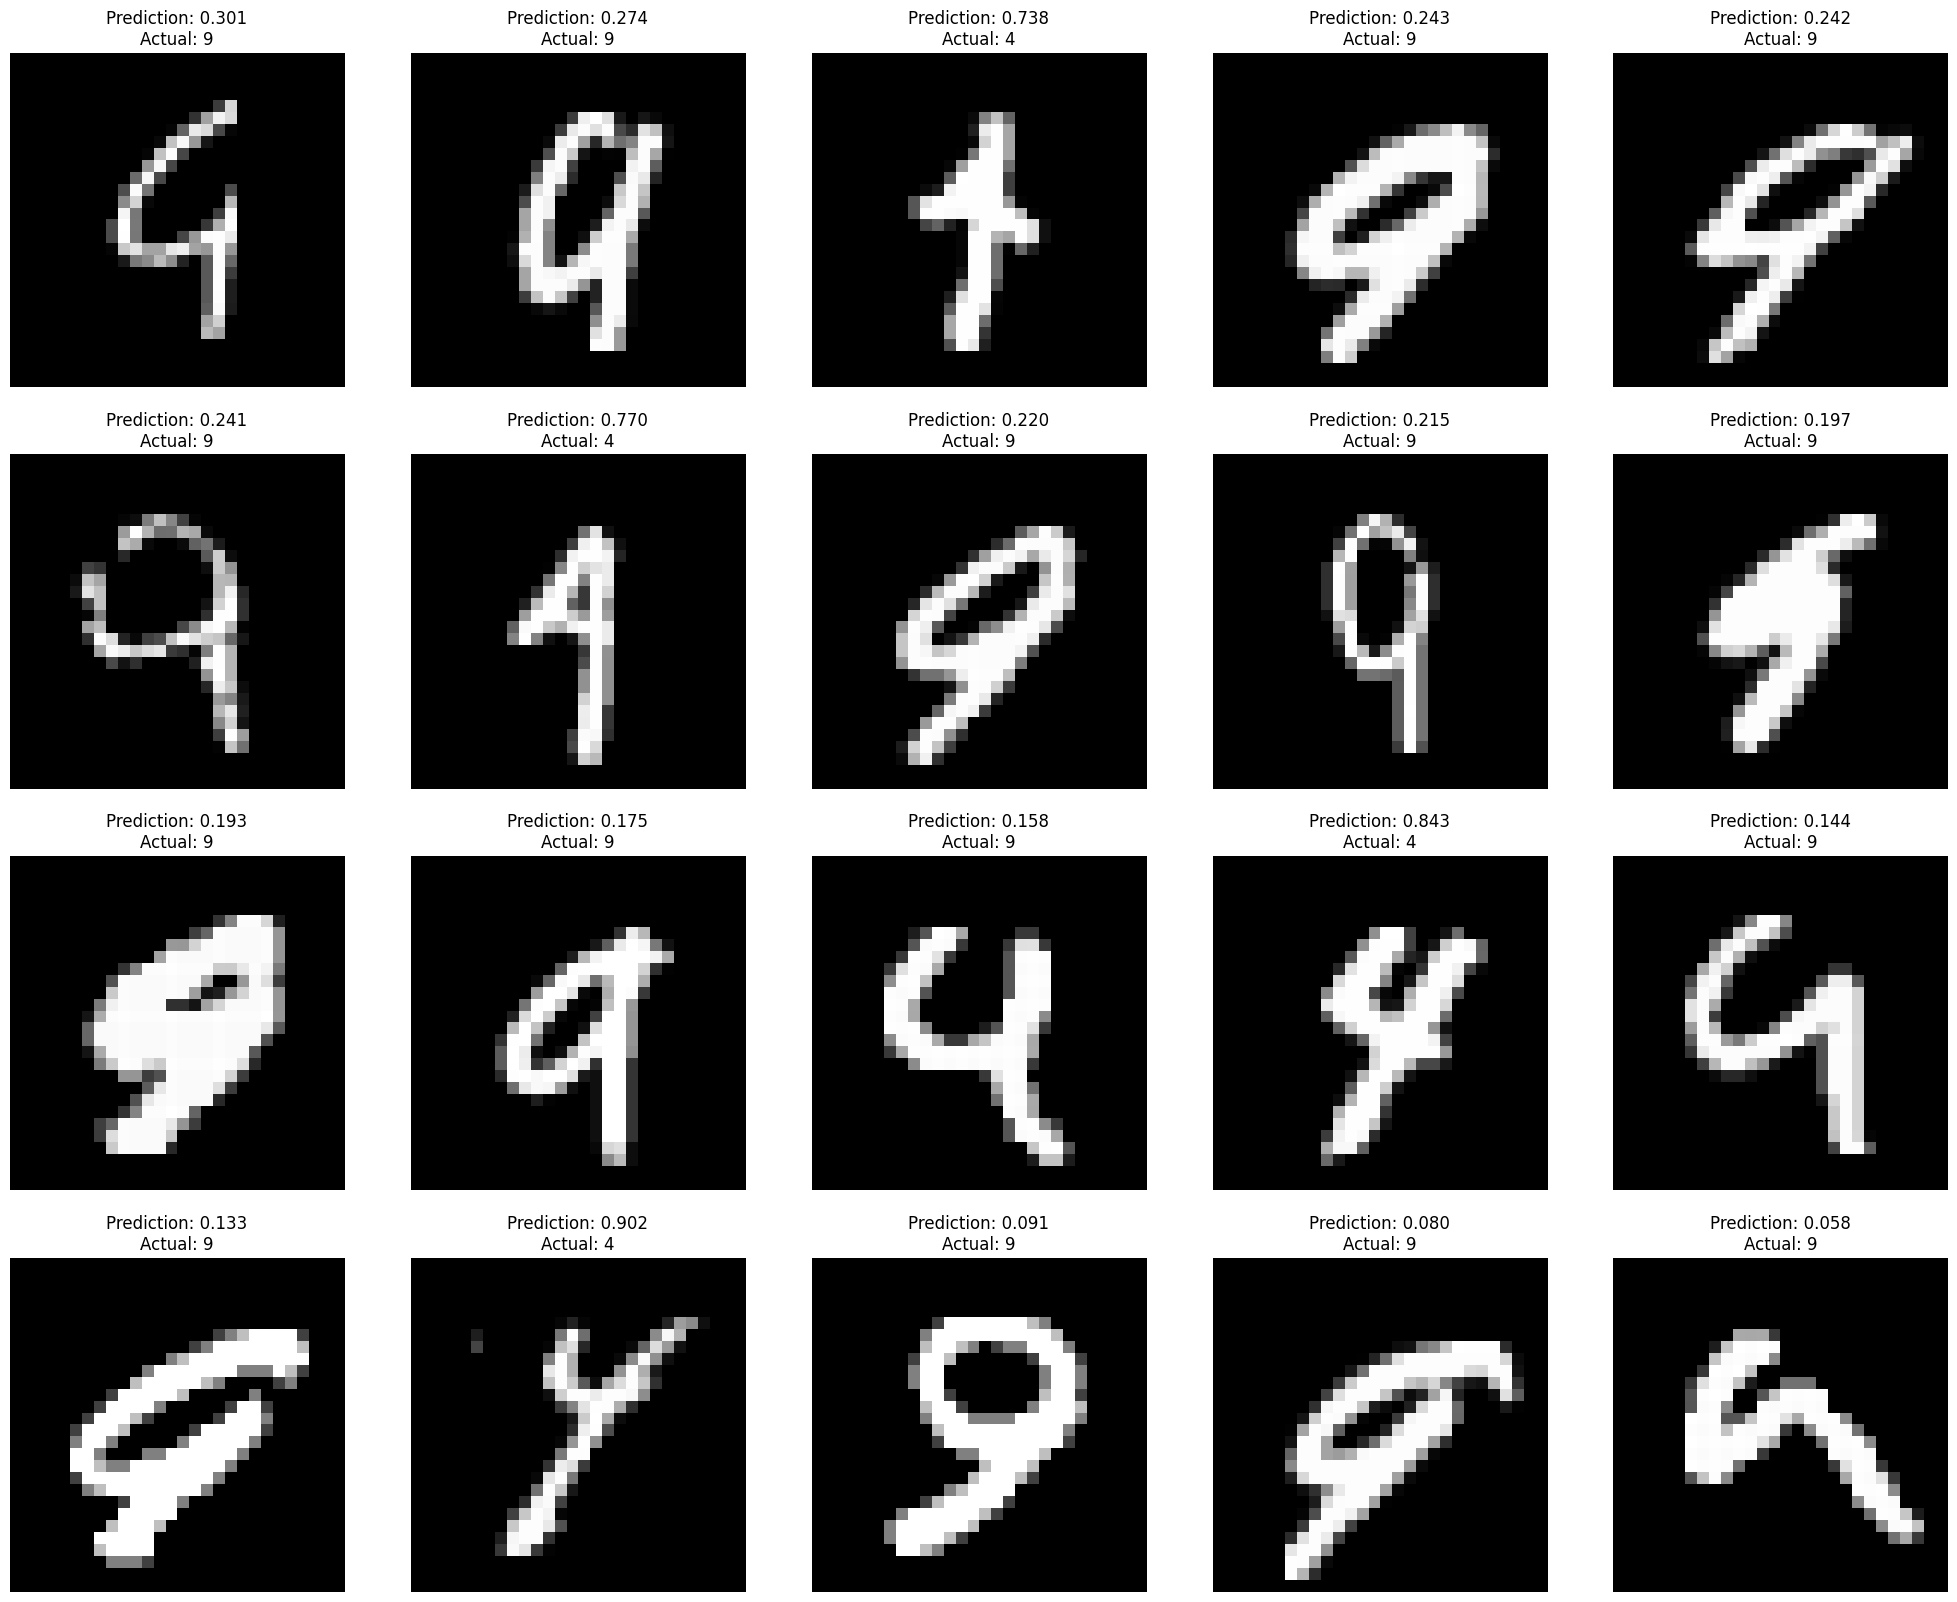

In [15]:
# Train the model
'''step - choose different learning rates and store them in a list and observe the changes '''
num_epochs = 200
expectation_epoch = 20
learning_rates = [.01]
regularization_strengths = [0.01]
criterion = nn.BCELoss()
show_incorrect = True

for regularization in regularization_strengths:
    for learning_rate in learning_rates:
        total_step = len(train_loader)
        max_accuracy = 0
        optimal_loss = 0
        optimal_epoch = 0
        #Define the Model Object and your optimizer
        model = LogisticRegressor(28*28, 1).to(device)
        early_stopper = EarlyStopper(0.05, 30)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=regularization)
        for epoch in range(num_epochs):
            total_loss = []
            for i, (images, labels) in enumerate(train_loader):
                # Move tensors to the configured device
                images = images.to(device)
                labels = labels.reshape(-1, 1).to(device)
                
                # Forward pass
                '''Step - Get Network outputs with forward propagation with current network weights'''
                outputs = model(images)

                '''Step - Get Loss by comparing outputs with True Labels after forward propagation'''
                loss = criterion(outputs, labels)

                # Backward and optimize
                
                '''Step - clear the gradients after each pass - Strongly recommended'''
                optimizer.zero_grad()
                '''Backpropagate the Loss to calculate gradient for each weight'''
                loss.backward()
                '''Update the weight using the learning rate'''
                optimizer.step()

                #Print Progress every 100 steps
                #if (i+1) % 100 == 0:
                #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                total_loss.append(loss.item())

            incorrect, accuracy = test_model(model, test_loader)
            
            if early_stopper.early_stop(accuracy):
                optimal_epoch = epoch + 1
                optimal_loss = np.mean(total_loss)
                break

                    
    # Test the model once you finish training  

        incorrect, accuracy = test_model(model, test_loader, show_incorrect)   
        print(f'Best accuracy of the network on the 1000 test images: {accuracy} %, at Epoch: {optimal_epoch}, with Train Loss: {optimal_loss:.3f} with learning rate: {learning_rate}, and {regularization} regularization')
        plt.show()


